# Simulating different telescopes
This notebooks provides examples in how to use the lenstronomy.SimulationAPI modules in simulating (realistic) mock lenses taylored to a specific observation and instrument and makes a montage of different telescope settings currently available.

The module enables to use the astronomical magnitude conventions and can translate those into the lenstronomy core module configurations.

In [1]:
import copy
import os
import numpy as np
import scipy
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

# make sure lenstronomy is installed, otherwise install the latest pip version
try:
    import lenstronomy
except:
    !pip install lenstronomy

# lenstronomy module import
from lenstronomy.Util import image_util, data_util, util
import lenstronomy.Plots.plot_util as plot_util
from lenstronomy.SimulationAPI.sim_api import SimAPI


## Define camera and observations
As an example, we define the camera and observational settings of a LSST-like observation. We define one camera setting and three different observations corresponding to g,r,i imaging.

For the complete list of possible settings, we refer to the SimulationAPI.observation_api classes. There are pre-configured settings which approximately mimic observations from current and future instruments. Be careful using those and check whether they are sufficiently accurate for your specific science case!

In [2]:
# Instrument setting from pre-defined configurations

from lenstronomy.SimulationAPI.ObservationConfig.DES import DES
from lenstronomy.SimulationAPI.ObservationConfig.LSST import LSST
from lenstronomy.SimulationAPI.ObservationConfig.Euclid import Euclid
from lenstronomy.SimulationAPI.ObservationConfig.Roman import Roman

DES_g = DES(band='g', psf_type='GAUSSIAN', coadd_years=3)
DES_r = DES(band='r', psf_type='GAUSSIAN', coadd_years=3)
DES_i = DES(band='i', psf_type='GAUSSIAN', coadd_years=3)
des = [DES_g, DES_r, DES_i]

LSST_g = LSST(band='g', psf_type='GAUSSIAN', coadd_years=10)
LSST_r = LSST(band='r', psf_type='GAUSSIAN', coadd_years=10)
LSST_i = LSST(band='i', psf_type='GAUSSIAN', coadd_years=10)
lsst = [LSST_g, LSST_r, LSST_i]

Roman_g = Roman(band='F062', psf_type='PIXEL', survey_mode='wide_area')
Roman_r = Roman(band='F106', psf_type='PIXEL', survey_mode='wide_area')
Roman_i = Roman(band='F184', psf_type='PIXEL', survey_mode='wide_area')
roman = [Roman_g, Roman_r, Roman_i]

# lenstronomy provides these setting to be imported with the SimulationAPI.ObservationConfig routines.



## Import real galaxy to be the source galaxy

In [3]:
# import NGC1300 jpg image and decompose it
import imageio.v2 as imageio
from scipy.ndimage import gaussian_filter

# find path to data
path = os.getcwd()
dirpath, _ = os.path.split(path)
module_path, _ = os.path.split(dirpath)
ngc_filename = os.path.join(module_path, 'Data/Galaxies/ngc1300.jpg')
# read data, this only works if you execute this notebook within the environment of the github repo!
ngc_data = imageio.imread(ngc_filename, mode='F', pilmode=None)

# subtract the median of an edge of the image
median = np.median(ngc_data[:200, :200])
ngc_data -= median

# resize the image to square size (add zeros at the edges of the non-square bits of the image)
nx, ny = np.shape(ngc_data)
n_min = min(nx, ny)
n_max = max(nx, ny)
ngc_square = np.zeros((n_max, n_max))
x_start = int((n_max - nx)/2.)
y_start = int((n_max - ny)/2.)
ngc_square[x_start:x_start+nx, y_start:y_start+ny] = ngc_data

# we slightly convolve the image with a Gaussian convolution kernel of a few pixels (optional)
sigma = 5
ngc_conv = gaussian_filter(ngc_square, sigma, mode='nearest', truncate=6)

# we now degrate the pixel resoluton by a factor.
# This reduces the data volume and increases the spead of the Shapelet decomposition
factor = 25  # lower resolution of image with a given factor
numPix_large = int(len(ngc_conv)/factor)
n_new = int((numPix_large-1)*factor)
ngc_cut = ngc_conv[0:n_new,0:n_new]
x, y = util.make_grid(numPix=numPix_large-1, deltapix=1)  # make a coordinate grid
ngc_data_resized = image_util.re_size(ngc_cut, factor)  # re-size image to lower resolution

print(np.sum(ngc_data_resized))

1788321.7625399919


## Define model settings

The model settings are handled by the SimulationAPI.model_api ModelAPI class. 
The role is to return instances of the lenstronomy LightModel, LensModel, PointSource modules according to the options chosen by the user. Currently, all other model choices are equivalent to the ones provided by LightModel, LensModel, PointSource.
The current options of the class instance only describe a subset of possibilities and we refer to the specific class instances for details about all the possibilities.

For this example, we chose a single lens plane and a single source plane, elliptical Sersic profile for the deflector, the interpolated Galaxy as the source and an additional lensed point source.

In [4]:
kwargs_model = {'lens_model_list': ['SIE', 'SHEAR'],  # list of lens models to be used
                'lens_light_model_list': ['SERSIC_ELLIPSE'],  # list of unlensed light models to be used
                'source_light_model_list': ['INTERPOL'],  # list of extended source models to be used, here we used the interpolated real galaxy
                'point_source_model_list': ['SOURCE_POSITION']  # list of point source models to be used
    }

## Brightness definitions in magnitude space
One core feature is the support of light profile amplitudes in astronomical magnitude space (at least for few selected well defined brightness profiles).

We first define all parameters in magnitude space and then use the SimAPI routine to translate the arguments into lenstronomy conventions used by the ImSim module. The second model of each light component we defined as 'INTERPOL', which sets an interpolation grid given an image. This can be used to past real galaxies as lenses or sources into lenstronomy.

In [5]:

# g-band

# lens light
kwargs_lens_light_mag_g = [{'magnitude': 15, 'R_sersic': 1.6, 'n_sersic': 4, 'e1': 0.1, 'e2': -0.1, 'center_x': 0, 'center_y': 0}]
# source light
kwargs_source_mag_g = [{'magnitude': 19, 'image': ngc_data_resized, 'center_x': 0, 'center_y': 0, 'phi_G': 0, 'scale': 0.005}]
# point source
kwargs_ps_mag_g = [{'magnitude': 18, 'ra_source': 0.03, 'dec_source': 0}]



# and now we define the colors of the other two bands

# r-band
g_r_source = 1  # color mag_g - mag_r for source
g_r_lens = -1  # color mag_g - mag_r for lens light
g_r_ps = 0
kwargs_lens_light_mag_r = copy.deepcopy(kwargs_lens_light_mag_g)
kwargs_lens_light_mag_r[0]['magnitude'] -= g_r_lens

kwargs_source_mag_r = copy.deepcopy(kwargs_source_mag_g)
kwargs_source_mag_r[0]['magnitude'] -= g_r_source

kwargs_ps_mag_r = copy.deepcopy(kwargs_ps_mag_g)
kwargs_ps_mag_r[0]['magnitude'] -= g_r_ps


# i-band
g_i_source = 2
g_i_lens = -2
g_i_ps = 0
kwargs_lens_light_mag_i = copy.deepcopy(kwargs_lens_light_mag_g)
kwargs_lens_light_mag_i[0]['magnitude'] -= g_i_lens

kwargs_source_mag_i = copy.deepcopy(kwargs_source_mag_g)
kwargs_source_mag_i[0]['magnitude'] -= g_i_source

kwargs_ps_mag_i = copy.deepcopy(kwargs_ps_mag_g)
kwargs_ps_mag_i[0]['magnitude'] -= g_i_ps


## setting lens model parameters
And finally we need a lens model. The default lensing units are in observed deflection angle (arc seconds) mapping the image to the source plane (reduced angles). In a single lens and single source plane model, this is all we need to specify and no futher cosmology is required.

In [6]:
kwargs_lens = [
    {'theta_E': 1.2, 'e1': 0.4, 'e2': -0.1, 'center_x': 0, 'center_y': 0},  # SIE model
    {'gamma1': 0.03, 'gamma2': 0.01, 'ra_0': 0, 'dec_0': 0}  # SHEAR model
]


## simluate image
Finally we can simulate the images with the ImageModel class instance and the lenstronomy parameters for the different bands. Note that in the specific example we included a point source (representing a quasar) in the center of the lensed galaxy. The SimulationAPI supports various options. Further down below we simulate multi-lens multi-source plane configurations too.

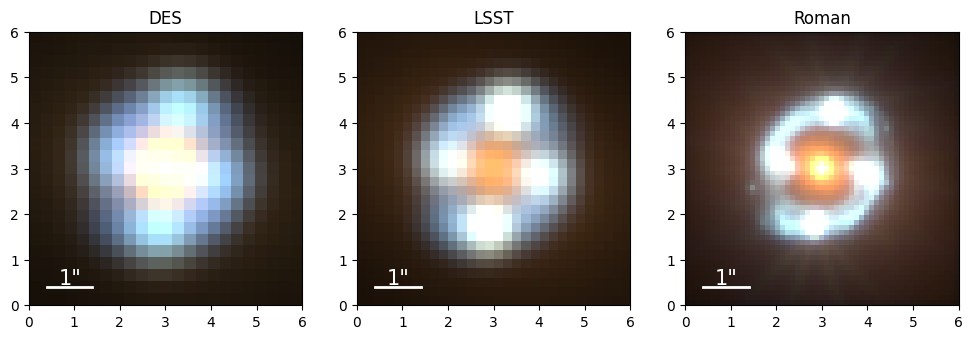

In [7]:
numpix = 64  # number of pixels per axis of the image to be modelled

# here we define the numerical options used in the ImSim module. 
# Have a look at the ImageNumerics class for detailed descriptions.
# If not further specified, the default settings are used.
kwargs_numerics = {'point_source_supersampling_factor': 1}


def simulate_rgb(ConfigList, size, kwargs_numerics):
    band_b, band_g, band_r = ConfigList
    kwargs_b_band = band_b.kwargs_single_band()
    kwargs_g_band = band_g.kwargs_single_band()
    kwargs_r_band = band_r.kwargs_single_band()
    
    # set number of pixels from pixel scale
    pixel_scale = kwargs_g_band['pixel_scale']
    numpix = int(round(size / pixel_scale))

    sim_b = SimAPI(numpix=numpix, kwargs_single_band=kwargs_b_band, kwargs_model=kwargs_model)
    sim_g = SimAPI(numpix=numpix, kwargs_single_band=kwargs_g_band, kwargs_model=kwargs_model)
    sim_r = SimAPI(numpix=numpix, kwargs_single_band=kwargs_r_band, kwargs_model=kwargs_model)

    # return the ImSim instance. With this class instance, you can compute all the
    # modelling accessible of the core modules. See class documentation and other notebooks.
    imSim_b = sim_b.image_model_class(kwargs_numerics)
    imSim_g = sim_g.image_model_class(kwargs_numerics)
    imSim_r = sim_r.image_model_class(kwargs_numerics)


    # turn magnitude kwargs into lenstronomy kwargs
    kwargs_lens_light_g, kwargs_source_g, kwargs_ps_g = sim_b.magnitude2amplitude(kwargs_lens_light_mag_g, kwargs_source_mag_g, kwargs_ps_mag_g)
    kwargs_lens_light_r, kwargs_source_r, kwargs_ps_r = sim_g.magnitude2amplitude(kwargs_lens_light_mag_r, kwargs_source_mag_r, kwargs_ps_mag_r)
    kwargs_lens_light_i, kwargs_source_i, kwargs_ps_i = sim_r.magnitude2amplitude(kwargs_lens_light_mag_i, kwargs_source_mag_i, kwargs_ps_mag_i)


    image_b = imSim_b.image(kwargs_lens, kwargs_source_g, kwargs_lens_light_g, kwargs_ps_g)
    image_g = imSim_g.image(kwargs_lens, kwargs_source_r, kwargs_lens_light_r, kwargs_ps_r)
    image_r = imSim_r.image(kwargs_lens, kwargs_source_i, kwargs_lens_light_i, kwargs_ps_i)

    # add noise
    image_b += sim_b.noise_for_model(model=image_b)
    image_g += sim_g.noise_for_model(model=image_g)
    image_r += sim_r.noise_for_model(model=image_r)

    # and plot it

    img = np.zeros((image_g.shape[0], image_g.shape[1], 3), dtype=float)
    #scale_max=10000
    def _scale_max(image): 
        flat=image.flatten()
        flat.sort()
        scale_max = flat[int(len(flat)*0.95)]
        return scale_max
    img[:,:,0] = plot_util.sqrt(image_b, scale_min=0, scale_max=_scale_max(image_b))
    img[:,:,1] = plot_util.sqrt(image_g, scale_min=0, scale_max=_scale_max(image_g))
    img[:,:,2] = plot_util.sqrt(image_r, scale_min=0, scale_max=_scale_max(image_r))
    data_class = sim_b.data_class
    return img, data_class

size = 6. # width of the image in units of arc seconds

img_des, coords_des = simulate_rgb(des, size=size, kwargs_numerics=kwargs_numerics)
img_lsst, coords_lss = simulate_rgb(lsst, size=size, kwargs_numerics=kwargs_numerics)
img_roman, coords_roman = simulate_rgb(roman, size=size, kwargs_numerics=kwargs_numerics)

from lenstronomy.Plots.plot_util import coordinate_arrows, scale_bar

f, axes = plt.subplots(1, 3, figsize=(12, 4))

ax = axes[0]
ax.imshow(img_des, aspect='equal', origin='lower', extent=[0, size, 0, size])
ax.set_title('DES')
# coordinate_arrows(ax, d=1, coords=coords_des, color='w', font_size=15, arrow_size=0.05)
scale_bar(ax, d=size, dist=1., text='1"', color='w', font_size=15, flipped=False)

ax = axes[1]
ax.imshow(img_lsst, aspect='equal', origin='lower', extent=[0, size, 0, size])
ax.set_title('LSST')
scale_bar(ax, d=size, dist=1., text='1"', color='w', font_size=15, flipped=False)

ax = axes[2]
ax.imshow(img_roman, aspect='equal', origin='lower', extent=[0, size, 0, size])
ax.set_title('Roman')
scale_bar(ax, d=size, dist=1., text='1"', color='w', font_size=15, flipped=False)
plt.show()